<a href="https://colab.research.google.com/github/rweigel/fieldline/blob/main/Field_Lines_Error_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing Required Packages

In [ ]:
import numpy as np
import math
from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import RegularGridInterpolator, NearestNDInterpolator, LinearNDInterpolator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

#### Defining Various Fields

In [ ]:
def Constant_Field(x,y,z):
    Fx = 1.0
    Fy = 0.0
    Fz = 1.0
    return np.array([Fx, Fy, Fz])

def Point_Field(x,y,z):
    #x,y,z=X
    r = np.sqrt(x**2 + y**2 + z**2)
    Fx = x/r**3
    Fy = y/r**3
    Fz = z/r**3
    return np.array([Fx, Fy, Fz])

def Dipole_Field1(X,d=1.0): #First form of Dipole Field which takes 1 positional argument
    x,y,z = X
    return Dipole_Field2(x,y,z,d=1.0)

def Dipole_Field2(x,y,z,d=1.0): #Second form of Dipole Field which takes 3 positional arguments
    #x,y,z = X
    D1 = np.power((x-d)**2+y**2+z**2, 1.5)
    D2 = np.power((x+d)**2+y**2+z**2, 1.5)
    Fx = (x-d)/D1 - (x+d)/D2
    Fy = y/D1 - y/D2
    Fz = z/D1 - z/D2
    return np.array([Fx, Fy, Fz])


#### Defining the trace function

In [ ]:
#This function employs the solve_ivp function of the scipy integration package

def trace(IC, Field, tol=1e-3, grid_spacing = 0.1):
    import types
    assert isinstance(Field, types.FunctionType)

    def dXds(s,X):
        F = Field(X)
        Fmag = np.linalg.norm(F)
        #if 1e-9 < Fmag < 1e+7:
        #    return (1/Fmag)*F
        #return [0., 0., 0.]
        return (1/Fmag)*F
        
    s_grid = np.arange(0,3.5,grid_spacing)
    soln = solve_ivp(fun=dXds, t_span=[s_grid[0], s_grid[-1]], 
                    y0=IC, t_eval=s_grid, rtol=tol, method = 'RK23').y
    return soln

In [ ]:
# The following are auxiliary functions that help in analyzing and comparing the error in Dipole Field line tracing.

def end_point(soln,r): #This function cuts off the solution when it enters a pre-defined radius 'r' 
    for i in range(soln.shape[1]):
        if (soln[0][i]+1)**2+soln[1][i]**2 < r:
            break
    return soln[0:2,i],i

def local_error(x,y): #This function outputs the local error when initial condition is [1,1,0]
    return ((x+1)**2+(y-1)**2)**(1/2)

def field_length(soln,r): #This function computes the length of the field line
    length = 0
    x = soln[0][0]  
    y = soln[1][0]
    j = end_point(soln,r)[1]
    for i in range(1, j+1):
        x2 = soln[0][i]
        y2 = soln[1][i]
        length += ((x2-x)**2+(y2-y)**2)**(1/2)
        x = x2
        y = y2
    return length

In [ ]:
#Using a very low tolerance and small grid spacing to compute an accurate value for the exact field length
true_length = field_length(trace([1,1,0],Dipole_Field1,tol=1e-7, grid_spacing = 1e-5),1) 
print(true_length)

3.0694399845840827


In [ ]:
IC = [1,1,0]
tol=1e-6
soln1 = trace(IC,Dipole_Field1,tol)

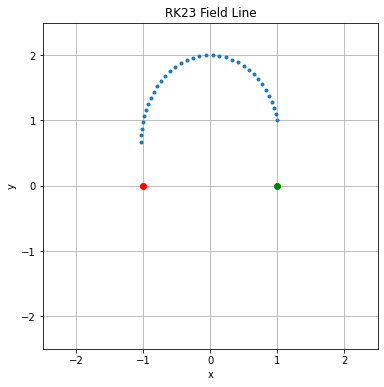

In [ ]:
## 2-D Plotting
fig = plt.figure(figsize=[6,6])
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.grid()
#for i in range(len(IC_list)):
plt.plot(soln1[0],soln1[1],'.')
plt.plot(1,0,'go') #Positive Charge at x=+d
plt.plot(-1,0,'ro') #Negative Charge at x=-d
plt.xlabel('x')
plt.ylabel('y')
plt.title("RK23 Field Line")
plt.show()

#### Non-Regular Grid Interpolator

In [ ]:
#This function interpolates the field values using the NDInterpolator function in the scipy interpolation package
#The grid may or may not be regular 

def interpolate(IC, Field, delta, method):
    X = np.arange(-4,4+delta,delta)
    Y = np.arange(-4,4+delta,delta)
    Z = np.arange(-4,4+delta,delta)

    coordinates = [(x,y,z) for x in X for y in Y for z in Z]
    Field_x = [Field(x,y,z)[0] for x in X for y in Y for z in Z]
    Field_y = [Field(x,y,z)[1] for x in X for y in Y for z in Z]
    Field_z = [Field(x,y,z)[2] for x in X for y in Y for z in Z]
    
    if method == 'nearest':
        Fx_interp = NearestNDInterpolator(coordinates,Field_x)
        Fy_interp = NearestNDInterpolator(coordinates,Field_y)
        Fz_interp = NearestNDInterpolator(coordinates,Field_z)
    elif method == 'linear':
        Fx_interp = LinearNDInterpolator(coordinates,Field_x)
        Fy_interp = LinearNDInterpolator(coordinates,Field_y)
        Fz_interp = LinearNDInterpolator(coordinates,Field_z)

    def Fcallable(v):
        return np.array([Fx_interp(v)[0], Fy_interp(v)[0], Fz_interp(v)[0]])
    return trace(IC,Fcallable)

#### Regular Grid Interpolator (Linear or Nearest)

In [ ]:
#This function interpolates the field values using the RegularGridInterpolator function in the scipy interpolation package
#The grid needs to be regular
#This method avoids expensive triagulation of the input data and is expected to be much faster than the non-regular grid interpolation

def regular_interp(IC, Field, delta, method):
    x = np.arange(-4,4+delta,delta)
    y = np.arange(-4,4+delta,delta)
    z = np.arange(-4,4+delta,delta)
    xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)
    data = Field(xg,yg,zg)
    
    Fx_interp = RegularGridInterpolator((x,y,z),data[0,:],method=method)
    Fy_interp = RegularGridInterpolator((x,y,z),data[1,:],method=method)
    Fz_interp = RegularGridInterpolator((x,y,z),data[2,:],method=method)

    def Fcallable(v):
        return np.array([Fx_interp(v)[0], Fy_interp(v)[0], Fz_interp(v)[0]])
    return trace(IC,Fcallable)

In [ ]:
IC = [1,1,0]
soln3 = interpolate(IC,Dipole_Field2,0.2,'nearest')
soln4 = regular_interp(IC,Dipole_Field2,0.2,'nearest')
soln5 = interpolate(IC,Dipole_Field2,0.2,'linear') #Takes around 40 seconds to run
soln6 = regular_interp(IC,Dipole_Field2,0.2,'linear')

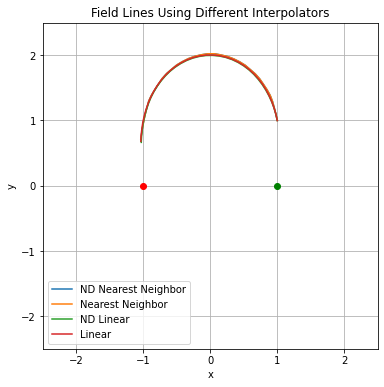

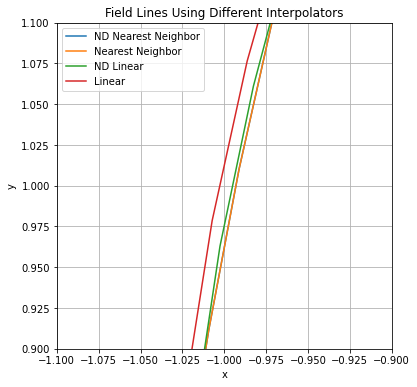

In [ ]:
#Comparing Regular and ND Interpolation

fig = plt.figure(figsize=[6,6])
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.grid()
plt.plot(soln3[0],soln3[1],label='ND Nearest Neighbor')
plt.plot(soln4[0],soln4[1],label='Nearest Neighbor')
plt.plot(soln5[0],soln5[1],label='ND Linear')
plt.plot(soln6[0],soln6[1],label='Linear')
plt.plot(1,0,'go') #Positive Charge at x=+d
plt.plot(-1,0,'ro') #Negative Charge at x=-d
plt.xlabel('x')
plt.ylabel('y')
plt.title("Field Lines Using Different Interpolators")
plt.legend()
plt.show()

fig = plt.figure(figsize=[6,6])
plt.xlim([-1.1, -0.9])
plt.ylim([0.9, 1.1])
plt.grid()
plt.plot(soln3[0],soln3[1],label='ND Nearest Neighbor')
plt.plot(soln4[0],soln4[1],label='Nearest Neighbor')
plt.plot(soln5[0],soln5[1],label='ND Linear')
plt.plot(soln6[0],soln6[1],label='Linear')
plt.plot(1,0,'go') #Positive Charge at x=+d
plt.plot(-1,0,'ro') #Negative Charge at x=-d
plt.xlabel('x')
plt.ylabel('y')
plt.title("Field Lines Using Different Interpolators")
plt.legend(loc="upper left")
plt.show()

On a closer look, the two linear methods don't overlap, despite both the methods using the same grid. This may be because of the fact that Linear ND Interpolator performs linear barycentric interpolation on a triangle constructed by the input data, whereas the Regular Grid Linear method avoids this expensive triangulation.

Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html

#### Plotting Errors

In [ ]:
IC = [1,1,0]
error_list1 = []
time_list1 = []
tol_list = []

for i in range(13):
    tol = 10**(-i)
    start = time.time()
    soln = trace(IC,Dipole_Field1,tol)
    end = time.time()
    length_error = np.abs(true_length - field_length(soln,1))
    error_list1.append(length_error)
    time_list1.append(end-start)
    tol_list.append(tol)


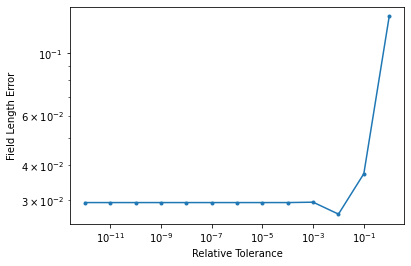

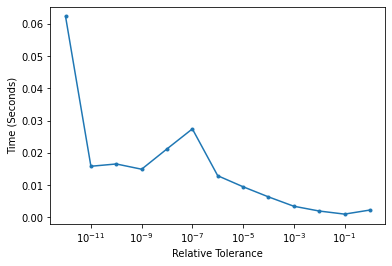

In [ ]:
plt.loglog(tol_list,error_list1,'.-')
plt.xlabel("Relative Tolerance")
plt.ylabel("Field Length Error")
plt.show()

plt.semilogx(tol_list,time_list1,'.-')
plt.xlabel("Relative Tolerance")
plt.ylabel("Time (Seconds)")
plt.show()



In [ ]:
IC = [1,1,0]
p=0.9
delta_list = [p, 3*p/4, 2*p/3, p/2, p/3, p/4, p/5, p/6, p/8] #,p/10, #p/15, p/20]
delta_list2 = [0.9, 0.8, 0.7, 0.6, 0.55, 0.45, 0.3, 0.2, 0.15, 0.1]

error_list2 = []
error_list3 = []
error_list4 = []
error_list5 = []

time_list2 = []
time_list3 = []
time_list4 = []
time_list5 = []


for delta in delta_list2:
   
    start = time.time()
    soln = interpolate(IC,Dipole_Field2, delta, 'nearest')
    end = time.time()
    length_error = np.abs(true_length - field_length(soln,1))
    error_list2.append(length_error)
    time_list2.append(end-start)
    print("Nearest Neighbor for Delta = ", delta, "; Time = ", np.round(end-start,2), "s")

    if delta > 0.15:
      start = time.time()
      soln = interpolate(IC,Dipole_Field2, delta, 'linear')
      end = time.time()
      length_error = np.abs(true_length - field_length(soln,1))
      error_list3.append(length_error)
      time_list3.append(end-start)
      print("Linear for Delta = ", delta, "; Time = ", np.round(end-start,2), "s")
    
    start = time.time()
    soln = regular_interp(IC,Dipole_Field2,delta,"linear")
    end = time.time()
    length_error = np.abs(true_length - field_length(soln,1))
    error_list4.append(length_error)
    time_list4.append(end-start)
    print("Regular Grid Linear for Delta = ", delta, "; Time = ", np.round(end-start,2), "s")
    
    start = time.time()
    soln = regular_interp(IC,Dipole_Field2,delta,"nearest")
    end = time.time()
    length_error = np.abs(true_length - field_length(soln,1))
    error_list5.append(length_error)
    time_list5.append(end-start)
    print("Regular Grid Nearest for Delta = ", delta, "; Time = ", np.round(end-start,2), "s")
    
    print("--------------")


Nearest Neighbor for Delta =  0.9 ; Time =  0.06 s
Linear for Delta =  0.9 ; Time =  0.35 s
Regular Grid Linear for Delta =  0.9 ; Time =  0.12 s
Regular Grid Nearest for Delta =  0.9 ; Time =  0.05 s
--------------
Nearest Neighbor for Delta =  0.8 ; Time =  0.09 s
Linear for Delta =  0.8 ; Time =  0.41 s
Regular Grid Linear for Delta =  0.8 ; Time =  0.13 s
Regular Grid Nearest for Delta =  0.8 ; Time =  0.06 s
--------------
Nearest Neighbor for Delta =  0.7 ; Time =  0.12 s
Linear for Delta =  0.7 ; Time =  0.92 s
Regular Grid Linear for Delta =  0.7 ; Time =  0.18 s
Regular Grid Nearest for Delta =  0.7 ; Time =  0.11 s
--------------
Nearest Neighbor for Delta =  0.6 ; Time =  0.2 s
Linear for Delta =  0.6 ; Time =  1.37 s
Regular Grid Linear for Delta =  0.6 ; Time =  0.14 s
Regular Grid Nearest for Delta =  0.6 ; Time =  0.19 s
--------------
Nearest Neighbor for Delta =  0.55 ; Time =  0.54 s
Linear for Delta =  0.55 ; Time =  3.73 s
Regular Grid Linear for Delta =  0.55 ; Tim

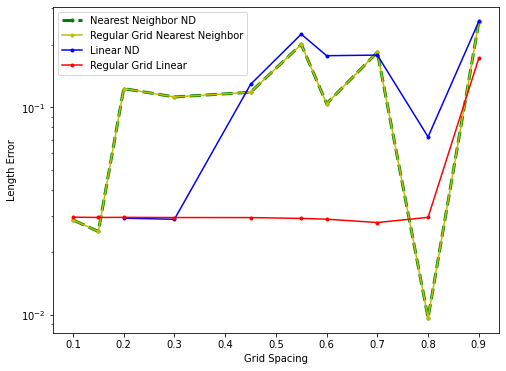

In [ ]:
plt.figure(figsize=[8,6])
plt.semilogy(delta_list2,error_list2,'g.--',label="Nearest Neighbor ND", linewidth = 3)
plt.semilogy(delta_list2,error_list5,'y.-',label="Regular Grid Nearest Neighbor")
plt.semilogy(delta_list2[0:-2],error_list3,'b.-',label="Linear ND")
plt.semilogy(delta_list2,error_list4, 'r.-',label="Regular Grid Linear")
plt.xlabel("Grid Spacing")
plt.ylabel("Length Error")
plt.legend()
plt.show()

#### Plotting Time

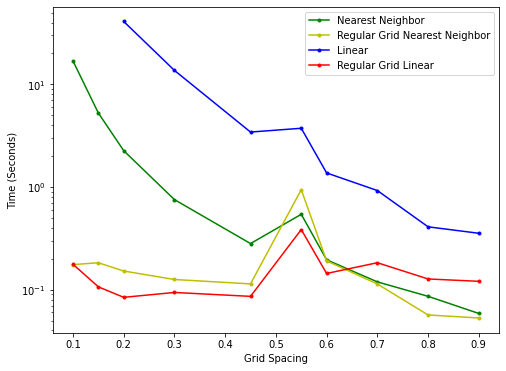

In [ ]:
plt.figure(figsize=[8,6])
plt.semilogy(delta_list2,time_list2,'g.-',label="Nearest Neighbor")
plt.semilogy(delta_list2,time_list5,'y.-',label="Regular Grid Nearest Neighbor")
plt.semilogy(delta_list2[0:-2],time_list3,'b.-',label="Linear")
plt.semilogy(delta_list2,time_list4,'r.-',label="Regular Grid Linear")
plt.xlabel("Grid Spacing")
plt.ylabel("Time (Seconds)")
plt.legend()
plt.show()